In [60]:
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [61]:
import pandas
import numpy as np
from configparser import ConfigParser
import sqlite3
from datetime import datetime

In [62]:
config = ConfigParser()
config.read("../config.ini")
sqlite_conn_string = config.get(section='NOTEBOOKS', option='sqlite3_conn_string')
conn = sqlite3.connect(sqlite_conn_string)

In [63]:
consultation_types_sql_text = """
SELECT  CASE WHEN legislation_type IS NULL THEN 'Miscellaneous' ELSE legislation_type END AS LegislationType,
        count(*) AS cnt FROM Legislation
WHERE is_public_consultation=1
GROUP BY legislation_type;
"""
consultation_types = pandas.read_sql_query(consultation_types_sql_text, conn)
print(consultation_types.sort_values('cnt',ascending=False).to_latex(index=False))

\begin{tabular}{lr}
\toprule
LegislationType & cnt \\
\midrule
Bill & 546 \\
Miscellaneous & 199 \\
Joint Ministerial Decision & 50 \\
Presidental Decree & 45 \\
Ministerial Decision & 40 \\
\bottomrule
\end{tabular}



In [64]:
sqlText = """ SELECT    ArticleAnalysis.*,
                        Legislation.date_posted,
                        VotedLegislation.date_posted as date_voted,
                        Legislation.ministry
                        FROM ArticleAnalysis
LEFT JOIN Legislation on Legislation.Id = ArticleAnalysis.p_legislation_id
LEFT JOIN Legislation as VotedLegislation on VotedLegislation.id = Legislation.final_legislation_id
"""
df = pandas.read_sql_query(sqlText,conn )
df.head()

,p_articleID,p_articleNo,f_articleID,f_articleNo,p_legislation_id,days_diff,diff_count,similarity_ratio,comments_allowed,total_comments,positivity_score,date_posted,date_voted,ministry
0,1,1,47429,1,1,15,85,0.935234,1,134,None,2023-07-10,2023-07-25,Υπουργείο Εσωτερικών
1,2,2,47430,2,1,15,10,0.979424,1,12,None,2023-07-10,2023-07-25,Υπουργείο Εσωτερικών
2,4,1,23146,1,3,12,43,0.780541,1,1,None,2023-03-30,2023-04-11,Υπουργείο Εσωτερικών
3,5,2,23147,2,3,12,143,0.794287,0,0,None,2023-03-30,2023-04-11,Υπουργείο Εσωτερικών
4,6,3,23148,3,3,12,271,0.882559,1,3,None,2023-03-30,2023-04-11,Υπουργείο Εσωτερικών


Data Sanity Checks

In [65]:
# Check for negative days diff
df[df['days_diff']<0][['p_legislation_id','days_diff']].drop_duplicates()
# Legislation 41 -> correct mapping is with Law 4950 (Bills are the same)
# Legislation 112 -> Wrong Match
# Legislation 245 -> It's mostly the same 
# Legislation 246 -> It's mostly the same

,p_legislation_id,days_diff
1068,41,-174
2558,112,-764
5563,245,-635
5575,246,-635


In [66]:
df = df[df['days_diff']>0]

In [67]:
df.rename(columns={'days_diff':'days_to_vote'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12464 entries, 0 to 12538
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   p_articleID       12464 non-null  int64  
 1   p_articleNo       12464 non-null  object 
 2   f_articleID       12464 non-null  int64  
 3   f_articleNo       12464 non-null  object 
 4   p_legislation_id  12464 non-null  int64  
 5   days_to_vote      12464 non-null  int64  
 6   diff_count        12464 non-null  int64  
 7   similarity_ratio  12464 non-null  float64
 8   comments_allowed  12464 non-null  int64  
 9   total_comments    12464 non-null  int64  
 10  positivity_score  0 non-null      object 
 11  date_posted       12464 non-null  object 
 12  date_voted        12464 non-null  object 
 13  ministry          12464 non-null  object 
dtypes: float64(1), int64(7), object(6)
memory usage: 1.4+ MB


### Prepare Data

In [68]:
def governemnt_period(dt):
    if dt >= datetime(2009,10,9) and dt <= datetime(2011,11,11):
        return "PASOK (Giorgos Papandreou)"
    if dt > datetime(2011,11,11) and dt <= datetime(2012,5,16):
        return "PASOK, New Democracy, LAOS (Loukas Papadimos)"
    if dt > datetime(2012,5,16) and dt <= datetime(2012,6,20):
        return "Caretaker Goverment (Panagiotis Pikramenos)"
    if dt > datetime(2012,6,20) and dt <= datetime(2015,1,16):
        return "New Democracy (Antonis Samaras)"
    if dt > datetime(2015,1,26) and dt <= datetime(2015,8,27):
        return "SYRIZA, ANEL (Alexis Tsipras)"
    if dt > datetime(2015,8,27) and dt <= datetime(2015,9,21):
        return "Caretaker Goverment (Vasiliki Thanou)"
    if dt > datetime(2015,9,21) and dt <= datetime(2019,7,8):
        return "SYRIZA, ANEL (Alexis Tsipras)"
    if dt > datetime(2019,8,9) and dt <= datetime(2023,5,25):
        return "New Democracy (Kyriakos Mitsotakis)"
    if dt > datetime(2023,5,25) and dt <= datetime(2023,7,26):
        return "Caretaker Goverment (Ioannis Sarmas)"
    if dt > datetime(2023,7,26):
        return "New Democracy (Kyriakos Mitsotakis 2nd Term)"

def translate_ministries(ministry:str) -> str:
    tr = {}
    tr.update({'Υπουργείο Εσωτερικών': 'Ministry of Interior'})
    tr.update({'Υπουργείο Υγείας': 'Ministry of Health'})
    tr.update({'Μετανάστευσης και Ασύλου': 'Ministry of Migration and Asylum'})
    tr.update({'Υπουργείο Υποδομών και Μεταφορών': 'Ministry of Infrastructure and Transportation'})
    tr.update({'Υπουργείο Αγροτικής Ανάπτυξης και Τροφίμων': 'Minstry of Rural Development and Food'})
    tr.update({'Υπουργείο Παιδείας, Θρησκευμάτων και Αθλητισμού': 'Ministry of Education and Sports'})
    tr.update({'Υπουργείο Πολιτισμού': 'Ministry of Culture'})
    tr.update({'Υπουργείο Ναυτιλίας και Νησιωτικής Πολιτικής': 'Ministry of Maritime Affairs & Insular Policy'})
    tr.update({'Υπουργείο Εθνικής Άμυνας': 'Ministry of National Defence'})
    tr.update({'Εργασίας και Κοινωνικής Ασφάλισης': 'Ministry of Labor and Social Security'})
    tr.update({'Υπουργείο Εξωτερικών': 'Ministry of Foreign Affairs'})
    tr.update({'Υπουργείο Κλιματικής Κρίσης και Πολιτικής Προστασίας': 'Ministry of Climate Crisis and Civil Protection'})
    tr.update({'Υπουργείο  Προστασίας του Πολίτη': 'Ministry of Citizen Protection'})
    tr.update({'Γενική Γραμματεία Επικοινωνίας και Ενημέρωσης': 'Secretariat Of Communications'})
    tr.update({'Υπουργείο Ψηφιακής Διακυβέρνησης': 'Ministry of Digital Governance'})
    tr.update({'Υπουργείο Τουρισμού': 'Ministry of Tourism'})
    tr.update({'Υπουργός Επικρατείας': 'Minister of State'})
    tr.update({'Υπουργείο Εθνικής Οικονομίας και Οικονομικών': 'Ministry of Economy and Finance'})
    tr.update({'Πρώην Υπουργείο Διοικητικής Ανασυγκρότησης': 'Ministry of Adminstrative Reconstruction'})
    tr.update({'Υπουργείο Ανάπτυξης': 'Ministry of Development'})
    tr.update({'Yπουργείο Περιβάλλοντος και Ενέργειας': 'Ministry of Environment and Energy'})
    tr.update({'Υπουργείο Δικαιοσύνης': 'Ministry of Justice'})
    tr.update({'Πρώην Υπουργείο Μακεδονίας - Θράκης': 'Ministry of Macedonia and Thrace'})

    return tr.get(ministry,ministry)

In [69]:
quantiles_total_comments = q=[0,0.5,0.75,0.9,0.95,0.99,1]
total_comments_q2_labels = ['0-50th perc.',
                            '50th-75th perc.',
                            '75th-90th perc.',
                            '90th-95th perc.',
                            '95-99th perc.',
                            '99th> perc.']
_, total_comments_bins = pandas.qcut(df['total_comments'], q=quantiles_total_comments, retbins=True, duplicates='drop')
for i in range(len(total_comments_bins)-1):
    total_comments_q2_labels[i] = total_comments_q2_labels[i] + f"({round(total_comments_bins[i],2)},{round(total_comments_bins[i+1],2)}]"
# total_comments_q2_labels[len(total_comments_q2_labels)-1] = total_comments_q2_labels[len(total_comments_q2_labels)-1] + total_comments_bins[len()]
print(total_comments_q2_labels)
bins = np.linspace(0,1,9)
_, days_to_vote_bins = pandas.qcut(df['days_to_vote'], q=bins, retbins=True, duplicates='drop')
days_to_vote_q_labels = []
for i in range(len(bins)-2):
    days_to_vote_q_labels.append(f"{bins[i]}th-{bins[i+1]}th perc.({days_to_vote_bins[i]},{days_to_vote_bins[i+1]}]")
days_to_vote_q_labels.append(f"{bins[len(bins)-2]}th> perc.({days_to_vote_bins[len(days_to_vote_bins)-2]},{days_to_vote_bins[len(days_to_vote_bins)-1]}]")
print(days_to_vote_q_labels)


['0-50th perc.(0.0,1.0]', '50th-75th perc.(1.0,4.0]', '75th-90th perc.(4.0,13.0]', '90th-95th perc.(13.0,25.85]', '95-99th perc.(25.85,142.0]', '99th> perc.(142.0,10633.0]']
['0.0th-0.125th perc.(6.0,25.0]', '0.125th-0.25th perc.(25.0,36.0]', '0.25th-0.375th perc.(36.0,51.0]', '0.375th-0.5th perc.(51.0,76.0]', '0.5th-0.625th perc.(76.0,105.0]', '0.625th-0.75th perc.(105.0,144.0]', '0.75th-0.875th perc.(144.0,222.0]', '0.875th> perc.(222.0,1591.0]']


In [70]:
df['date_posted'] = pandas.to_datetime(df['date_posted'])
df['date_posted_y'] = df['date_posted'].dt.year
df['date_posted_m'] = df['date_posted'].dt.month
df['total_comments_q'] = pandas.qcut(df['total_comments'],q=np.linspace(0,1,30),
                                     labels=False,
                                     duplicates='drop')
df['total_comments_cat'] = pandas.qcut(df['total_comments'],q=[0,0.5,0.75,0.9,0.95,0.99,1],
                                        labels=total_comments_q2_labels,
                                     duplicates='drop').astype(str)
df['days_to_vote_cat'] = pandas.qcut(df['days_to_vote'],q=np.linspace(0,1,9),
                                labels=days_to_vote_q_labels,
                                duplicates='drop')
df['goverment_period'] = df['date_posted'].apply(governemnt_period)
df['ministry'] = df['ministry'].apply(translate_ministries)
df.head(10)

,p_articleID,p_articleNo,f_articleID,f_articleNo,p_legislation_id,days_to_vote,diff_count,similarity_ratio,comments_allowed,total_comments,positivity_score,date_posted,date_voted,ministry,date_posted_y,date_posted_m,total_comments_q,total_comments_cat,days_to_vote_cat,goverment_period
0,1,1,47429,1,1,15,85,0.935234,1,134,None,2023-07-10,2023-07-25,Ministry of Interior,2023,7,10,"95-99th perc.(25.85,142.0]","0.0th-0.125th perc.(6.0,25.0]",Caretaker Goverment (Ioannis Sarmas)
1,2,2,47430,2,1,15,10,0.979424,1,12,None,2023-07-10,2023-07-25,Ministry of Interior,2023,7,7,"75th-90th perc.(4.0,13.0]","0.0th-0.125th perc.(6.0,25.0]",Caretaker Goverment (Ioannis Sarmas)
2,4,1,23146,1,3,12,43,0.780541,1,1,None,2023-03-30,2023-04-11,Ministry of Interior,2023,3,0,"0-50th perc.(0.0,1.0]","0.0th-0.125th perc.(6.0,25.0]",New Democracy (Kyriakos Mitsotakis)
3,5,2,23147,2,3,12,143,0.794287,0,0,None,2023-03-30,2023-04-11,Ministry of Interior,2023,3,0,"0-50th perc.(0.0,1.0]","0.0th-0.125th perc.(6.0,25.0]",New Democracy (Kyriakos Mitsotakis)
4,6,3,23148,3,3,12,271,0.882559,1,3,None,2023-03-30,2023-04-11,Ministry of Interior,2023,3,2,"50th-75th perc.(1.0,4.0]","0.0th-0.125th perc.(6.0,25.0]",New Democracy (Kyriakos Mitsotakis)
5,7,4,23149,4,3,12,488,0.070305,0,0,None,2023-03-30,2023-04-11,Ministry of Interior,2023,3,0,"0-50th perc.(0.0,1.0]","0.0th-0.125th perc.(6.0,25.0]",New Democracy (Kyriakos Mitsotakis)
6,8,5,23150,5,3,12,292,0.719588,1,4,None,2023-03-30,2023-04-11,Ministry of Interior,2023,3,3,"50th-75th perc.(1.0,4.0]","0.0th-0.125th perc.(6.0,25.0]",New Democracy (Kyriakos Mitsotakis)
7,9,6,23151,6,3,12,138,0.918103,1,7,None,2023-03-30,2023-04-11,Ministry of Interior,2023,3,5,"75th-90th perc.(4.0,13.0]","0.0th-0.125th perc.(6.0,25.0]",New Democracy (Kyriakos Mitsotakis)
8,10,7,23152,7,3,12,15,0.981818,1,5,None,2023-03-30,2023-04-11,Ministry of Interior,2023,3,4,"75th-90th perc.(4.0,13.0]","0.0th-0.125th perc.(6.0,25.0]",New Democracy (Kyriakos Mitsotakis)
9,12,9,23154,9,3,12,71,0.818121,0,0,None,2023-03-30,2023-04-11,Ministry of Interior,2023,3,0,"0-50th perc.(0.0,1.0]","0.0th-0.125th perc.(6.0,25.0]",New Democracy (Kyriakos Mitsotakis)


In [71]:
# Remove Ioannis Sarmas Goverment From Analysis
df = df[df['date_posted']<=datetime(2023,5,25)]

## Descriptive Statistics

In [72]:
print(df[['days_to_vote','similarity_ratio','comments_allowed','total_comments']].describe().round(3).to_latex())

\begin{tabular}{lrrrr}
\toprule
 & days_to_vote & similarity_ratio & comments_allowed & total_comments \\
\midrule
count & 12462.000000 & 12462.000000 & 12462.000000 & 12462.000000 \\
mean & 110.628000 & 0.658000 & 0.560000 & 11.425000 \\
std & 128.482000 & 0.249000 & 0.496000 & 139.725000 \\
min & 6.000000 & 0.050000 & 0.000000 & 0.000000 \\
25% & 36.000000 & 0.482000 & 0.000000 & 0.000000 \\
50% & 76.000000 & 0.723000 & 1.000000 & 1.000000 \\
75% & 144.000000 & 0.871000 & 1.000000 & 4.000000 \\
max & 1591.000000 & 0.998000 & 1.000000 & 10633.000000 \\
\bottomrule
\end{tabular}



In [73]:
df['ministry'].describe()

count                               12462
unique                                 23
top       Ministry of Economy and Finance
freq                                 1946
Name: ministry, dtype: object

# Plotting With Matplotlib

#### TODO
1. Restructure `scripts` folder, keep only important scrits and put the rest into different folder
2. add script that populates jaccard similarity and embeddings similarity
3. add script to populate embeddings from file
4. plot data
5. Read Time-Series, matplotlib documentation

In [74]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [75]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [76]:
plt.style.use("classic")

### Plot Similarity Per Time

C:\Users\aneme\AppData\Local\Temp\ipykernel_9172\2633831670.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


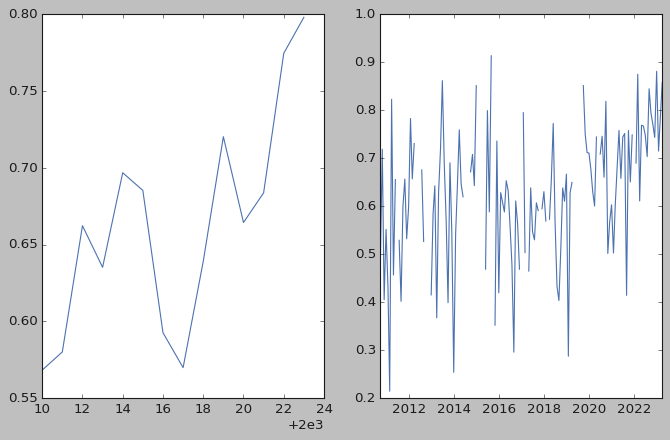

In [77]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,6))
df1 = df.groupby('date_posted_y')['similarity_ratio'].mean()
ax1.plot(df1)

df2 = df[['date_posted','similarity_ratio']]
df2.set_index('date_posted',inplace=True)
df2 = df2.resample("M").mean()
# df2.head()
ax2.plot(df2)
fig.show()

In [78]:
df[[ 'total_comments', 'similarity_ratio','days_to_vote' ]].describe().round(2)

,total_comments,similarity_ratio,days_to_vote
count,12462.00,12462.00,12462.00
mean,11.42,0.66,110.63
std,139.72,0.25,128.48
min,0.00,0.05,6.00
25%,0.00,0.48,36.00
50%,1.00,0.72,76.00
75%,4.00,0.87,144.00
max,10633.00,1.00,1591.00


In [79]:
print(df[[ 'total_comments', 'similarity_ratio','days_to_vote' ]].describe().round(2).to_latex())

\begin{tabular}{lrrr}
\toprule
 & total_comments & similarity_ratio & days_to_vote \\
\midrule
count & 12462.000000 & 12462.000000 & 12462.000000 \\
mean & 11.420000 & 0.660000 & 110.630000 \\
std & 139.720000 & 0.250000 & 128.480000 \\
min & 0.000000 & 0.050000 & 6.000000 \\
25% & 0.000000 & 0.480000 & 36.000000 \\
50% & 1.000000 & 0.720000 & 76.000000 \\
75% & 4.000000 & 0.870000 & 144.000000 \\
max & 10633.000000 & 1.000000 & 1591.000000 \\
\bottomrule
\end{tabular}



In [80]:
df['total_comments'].quantile(np.linspace(0,1,11))

0.0        0.0
0.1        0.0
0.2        0.0
0.3        0.0
0.4        0.0
0.5        1.0
0.6        2.0
0.7        3.0
0.8        6.0
0.9       13.0
1.0    10633.0
Name: total_comments, dtype: float64

In [81]:
df['total_comments'].quantile(np.linspace(.9,1,11))

0.90       13.00
0.91       14.00
0.92       16.00
0.93       19.00
0.94       22.00
0.95       25.00
0.96       32.00
0.97       44.00
0.98       71.78
0.99      142.00
1.00    10633.00
Name: total_comments, dtype: float64

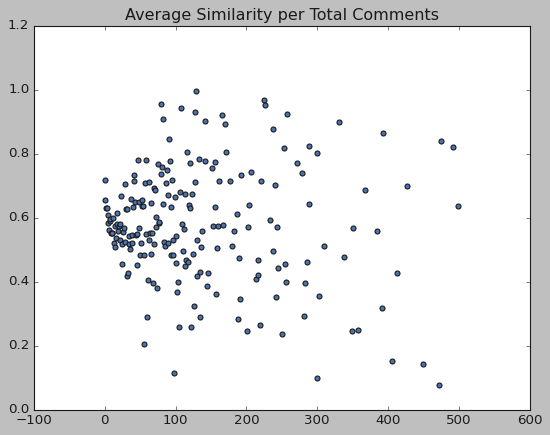

In [82]:
fig, ax = plt.subplots()
df0 = df[df['total_comments']<500]
df0 = df0.groupby(df0['total_comments'])['similarity_ratio'].mean()
ax.scatter(df0.index, df0.values)
ax.set_title("Average Similarity per Total Comments")
plt.show()

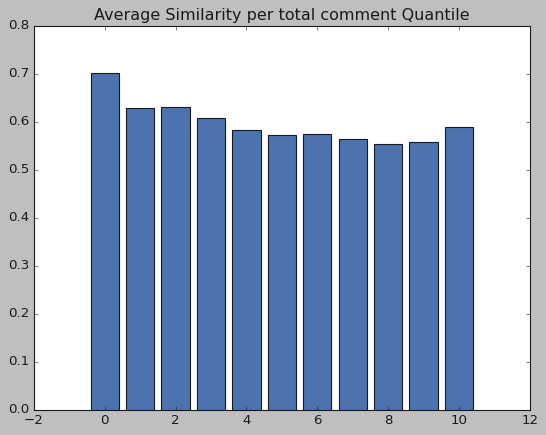

In [83]:
fig, ax = plt.subplots()
df3 = df.groupby('total_comments_q')['similarity_ratio'].mean().reset_index()
df3.head()
# df3['similarity_q'] = pandas.Categorical(df['similarity_q'], categories=range(4), ordered=True)

ax.bar(df3['total_comments_q'],df3['similarity_ratio'])
ax.set_title("Average Similarity per total comment Quantile")
# df3.index
plt.show()

1. scatter plot per total comment and similairity with alpha value
2. add count as a visual cue to indicate high and low count
3. run regression with total comments, days_diff, ministry and goverment
4. run similarities with jaccard and cosine (create view)

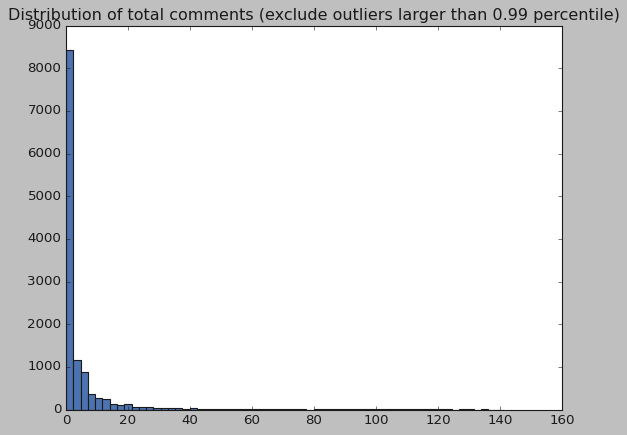

In [84]:
fig, ax = plt.subplots()

ax.hist(df[df['total_comments']<np.quantile(df['total_comments'],q=0.99)]['total_comments'], bins=60)
ax.set_title("Distribution of total comments (exclude outliers larger than 0.99 percentile)")
plt.show()

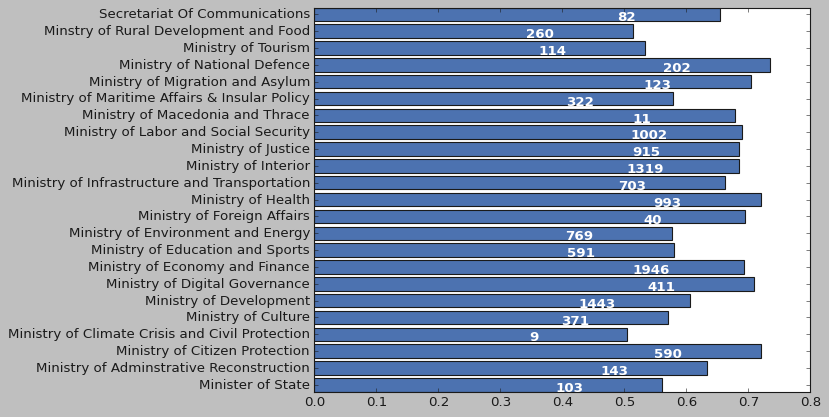

In [85]:
fig, ax = plt.subplots()
df4 = df.groupby('ministry')['similarity_ratio'].agg(['mean','count']).reset_index()

# df4.head()

bars = ax.barh(df4['ministry'], df4['mean'])
              
for bar,count in zip(bars, df4['count']):
    ax.text(bar.get_width()- 0.15,
            bar.get_y(),
            str(count),
            ha='center',
            color='white',
            fontweight='bold' )
plt.show()

C:\Users\aneme\AppData\Local\Temp\ipykernel_16704\1883386213.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=plt.cm.get_cmap('tab10')(np.arange(len(df4))),

# Plotting with Seaborn

In [86]:
import seaborn as sns
sns.set_theme()
sns.set_style("white")
sns.set_context("notebook")
sns.set_palette(palette="tab10")

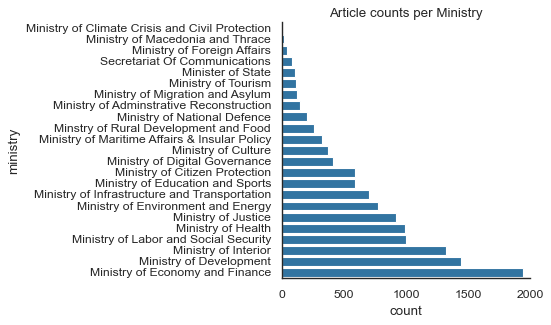

In [87]:
fig, ax1 = plt.subplots(figsize=(4,4))

sns.countplot(data=df,
              y='ministry',
              order=df['ministry'].value_counts().sort_values().reset_index()['ministry'],
              ax=ax1)

ax1.set_title("Article counts per Ministry")
sns.despine()
plt.savefig(r"C:\Users\aneme\OneDrive\Υπολογιστής\aueb\thesis2\cleanthesis\gfx\article_count_per_ministry.pdf", format="pdf", bbox_inches="tight")

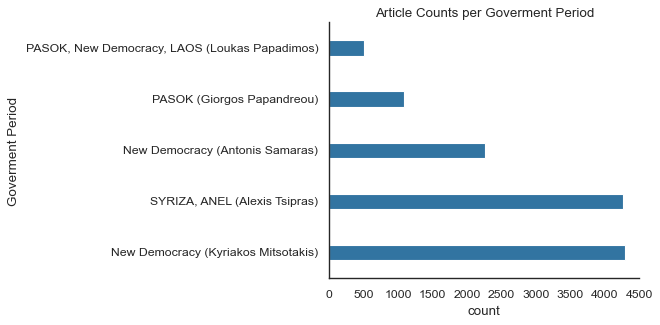

In [117]:
fig, ax = plt.subplots(figsize=(5,4))
sns.countplot(data=df,
              y='goverment_period',
              order=df['goverment_period'].value_counts().sort_values().reset_index()['goverment_period'],
              width=0.3)
plt.title("Article Counts per Goverment Period")
plt.ylabel("Goverment Period")

sns.despine()
plt.savefig(r"C:\Users\aneme\OneDrive\Υπολογιστής\aueb\thesis2\cleanthesis\gfx\article_counts_goverment.pdf", format="pdf", bbox_inches="tight")

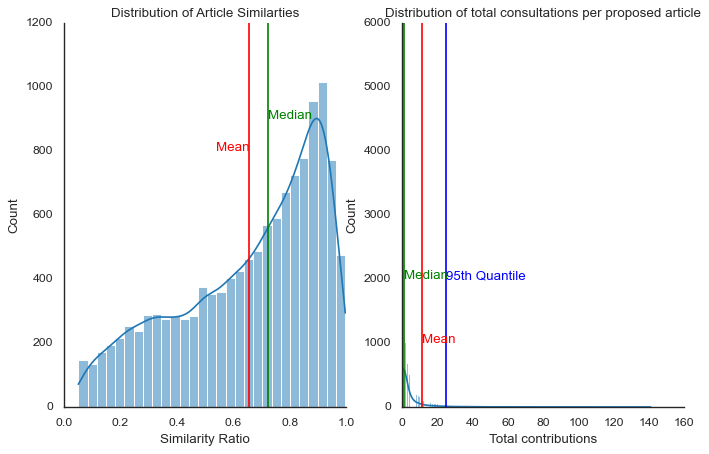

In [118]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,6))
sns.histplot(data=df,
             x="similarity_ratio",
             kde=True,
             ax=ax1)
ax1.axvline(df['similarity_ratio'].mean(), color='red')
ax1.axvline(df['similarity_ratio'].median(), color='green')

mean_value = df['similarity_ratio'].mean()
median_value = df['similarity_ratio'].median()

default_ticks, default_labels = plt.xticks()[0], plt.xticks()[1]
custom_ticks = [mean_value, median_value]
custom_labels = [f'{mean_value:.2f}', f'{median_value:.2f}']
all_ticks = list(default_ticks) + custom_ticks
all_labels = list(default_labels) + custom_labels

# ax1.xticks(all_ticks, all_labels)
# ax1.xaxis.set_ticks(all_ticks,all_labels)
ax1.text(mean_value,800,s="Mean", horizontalalignment='right', color = 'red')
ax1.text(median_value,900,s="Median", horizontalalignment='left', color = 'green' )
ax1.set_title("Distribution of Article Similarties")
ax1.set_xlabel("Similarity Ratio")

sns.histplot(data=df[df['total_comments']<np.quantile(df['total_comments'],q=.99)],
             x='total_comments',
             kde=True,
             ax=ax2)
ax2.axvline(df['total_comments'].mean(), color='red')
ax2.axvline(df['total_comments'].median(), color='green')
ax2.axvline(df['total_comments'].quantile(q=0.95), color='blue')

ax2.text(df['total_comments'].mean(),1000,s="Mean", horizontalalignment='left', color = 'red')
ax2.text(df['total_comments'].median(),2000,s="Median", horizontalalignment='left', color = 'green' )
ax2.text(df['total_comments'].quantile(q=.95),2000,s="95th Quantile", horizontalalignment='left', color = 'blue' )
ax2.set_title('Distribution of total consultations per proposed article')
ax2.set_xlabel("Total contributions")
sns.despine()
plt.savefig(r"C:\Users\aneme\OneDrive\Υπολογιστής\aueb\thesis2\cleanthesis\gfx\two_histograms.pdf", format="pdf", bbox_inches="tight")
plt.show()

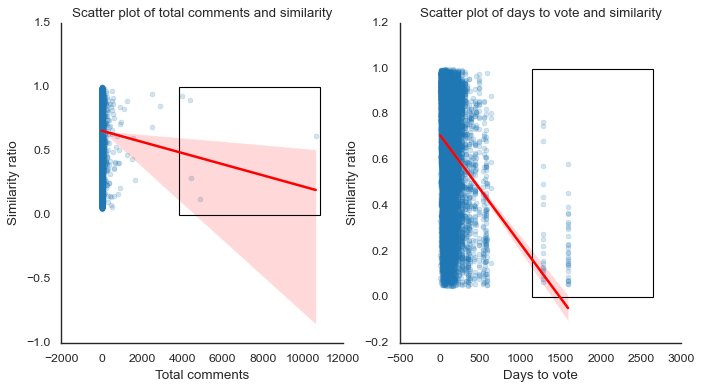

In [120]:
fig, (ax1,ax2) = plt.subplots(ncols=2,nrows=1, figsize=(10,5))
sns.regplot(data=df,
                x="total_comments",
                y="similarity_ratio",
                ax=ax1,
                line_kws={'color':'red'},
                scatter_kws={'alpha':0.2}
                )
sns.regplot(data=df,
                x="days_to_vote",
                y="similarity_ratio",
                ax=ax2,
                line_kws={'color':'red'},
                scatter_kws={'alpha':0.2}
                )
ax1.set_title("Scatter plot of total comments and similarity")
ax1.set_xlabel("Total comments")
ax1.set_ylabel("Similarity ratio")
ax2.set_title("Scatter plot of days to vote and similarity")
ax2.set_xlabel("Days to vote")
ax2.set_ylabel("Similarity ratio")
#Rect: xy, width, height
ax1.add_patch(patches.Rectangle((3850,0),7000,1, edgecolor='black', fill=False))
ax2.add_patch(patches.Rectangle((1150,0),1500,1, fill=False,edgecolor='black'))
sns.despine()
plt.savefig(r"C:\Users\aneme\OneDrive\Υπολογιστής\aueb\thesis2\cleanthesis\gfx\results_two_scatters.pdf", format="pdf", bbox_inches="tight")


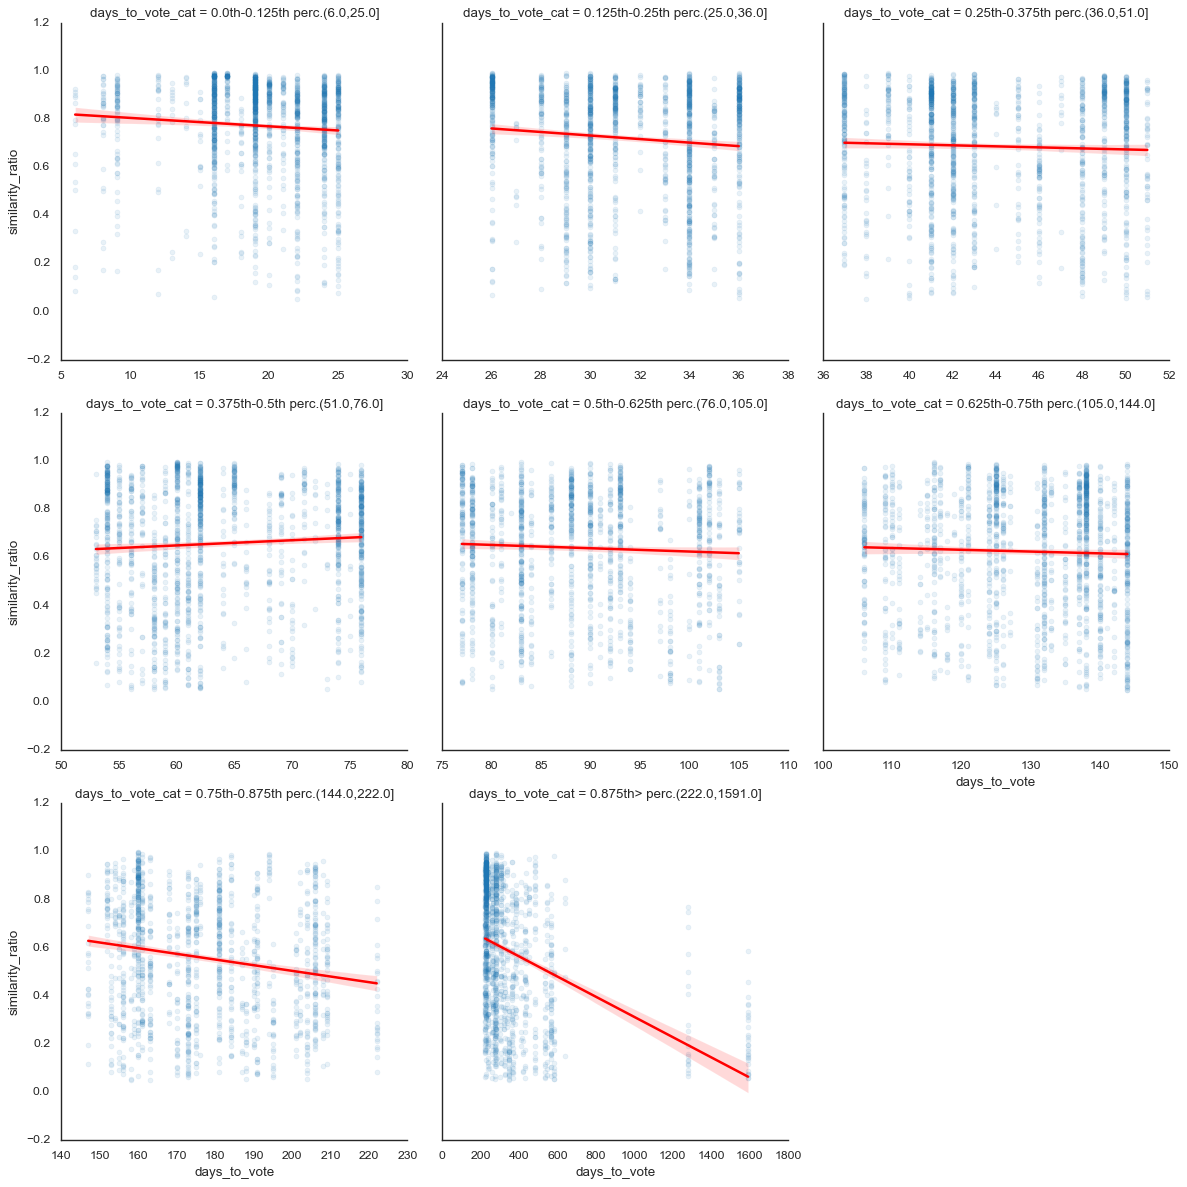

In [121]:
sns.lmplot(data=df,
                x='days_to_vote',
                y='similarity_ratio',
                col='days_to_vote_cat',
                col_wrap=3,
                col_order=days_to_vote_q_labels,
                facet_kws={'sharex':False},
                scatter_kws={'alpha':0.1},
                line_kws={'color':'red'}
                )

plt.savefig(r"C:\Users\aneme\OneDrive\Υπολογιστής\aueb\thesis2\cleanthesis\gfx\results_days_diff_bins.pdf", format="pdf", bbox_inches="tight")

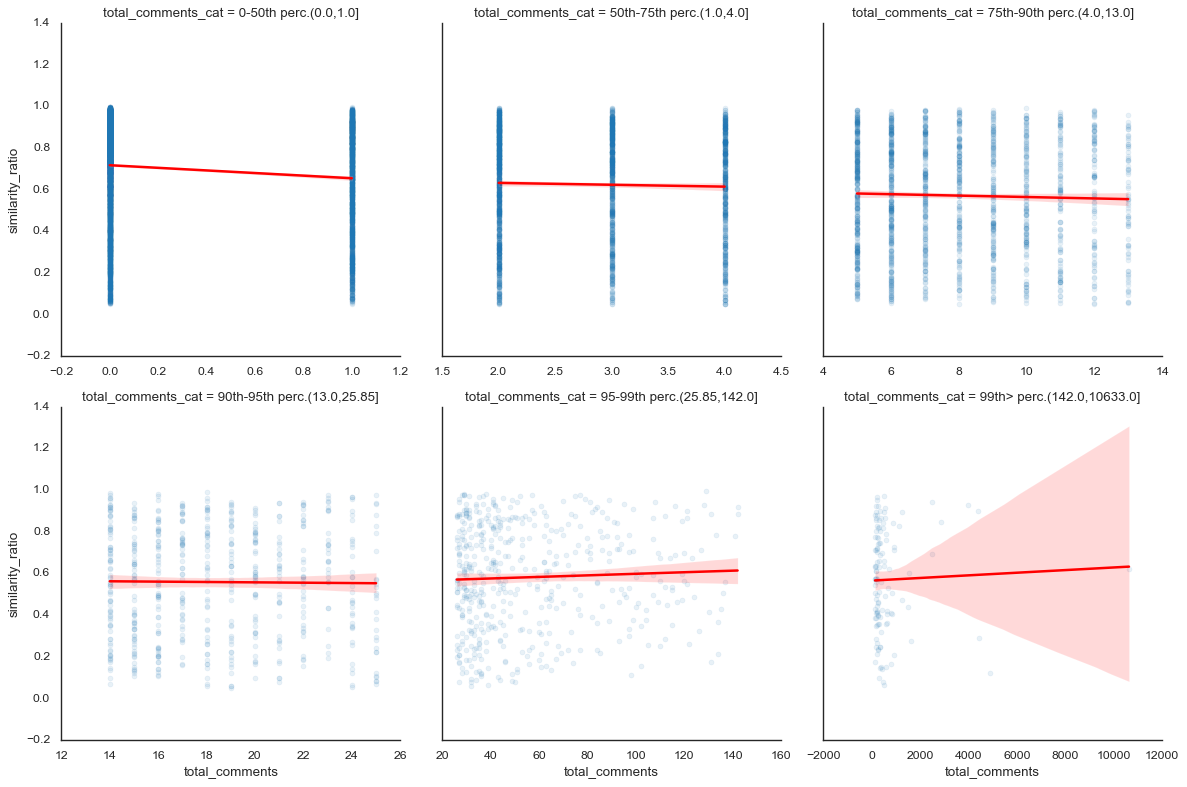

In [122]:
sns.lmplot(data=df,
                x='total_comments',
                y='similarity_ratio',
                col='total_comments_cat',
                col_wrap=3,
                col_order=total_comments_q2_labels,
                facet_kws={'sharex':False},
                scatter_kws={'alpha':0.1},
                line_kws={'color':'red'}
                )

plt.savefig(r"C:\Users\aneme\OneDrive\Υπολογιστής\aueb\thesis2\cleanthesis\gfx\results_total_comments_bin.pdf", format="pdf", bbox_inches="tight")

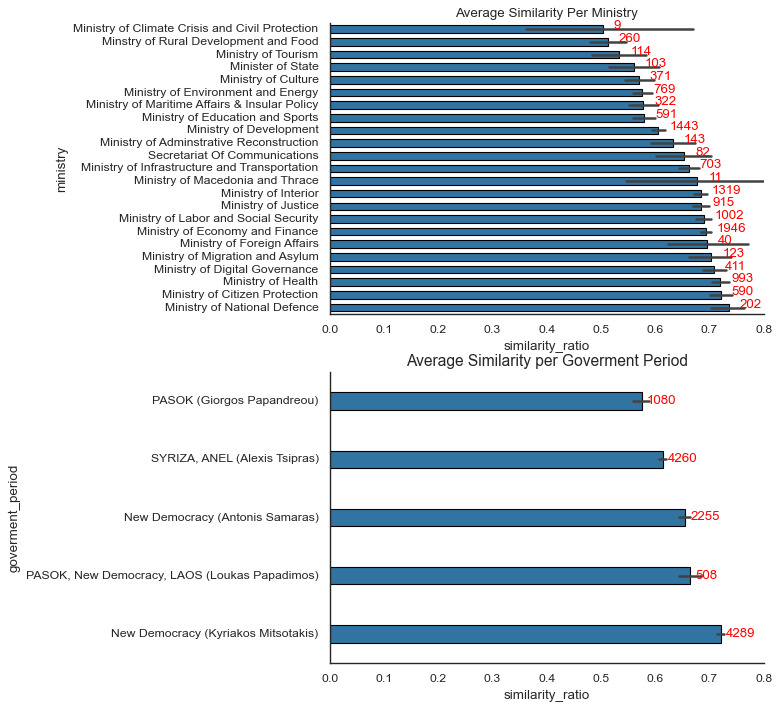

In [124]:
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(7,10))
counts = df.groupby('ministry')['similarity_ratio'].agg([ "mean","count" ]).reset_index().sort_values('mean')['count']
sns.barplot(data=df,
        x='similarity_ratio',
        y='ministry',
        edgecolor='black',
        order=df.groupby('ministry')['similarity_ratio'].mean().reset_index().sort_values('similarity_ratio')['ministry'],
        width=0.6,
        ax=ax1
        )
for idx,p in enumerate(ax1.patches):
        # print(p.get_x())
        # print(p.get_width())
        ax1.text(p.get_width() + 0.02,p.get_y()+0.30, counts.iloc[idx],color='red')
ax1.set_title("Average Similarity Per Ministry")
counts_2 = df.groupby('goverment_period')['similarity_ratio'].agg([ "mean","count" ]).reset_index().sort_values('mean')['count']
sns.barplot(data=df,
        x='similarity_ratio',
        y='goverment_period',
        edgecolor='black',
        width=0.3,
        order=df.groupby('goverment_period')['similarity_ratio'].mean().reset_index().sort_values('similarity_ratio')['goverment_period'],
        ax=ax2
            )
for idx,p in enumerate(ax2.patches):
        # print(p.get_x())
        # print(p.get_width())
        ax2.text(p.get_width() + 0.01,p.get_y()+0.2, counts_2.iloc[idx],color='red')
ax2.set_title("Average Similarity per Goverment Period",fontsize=14)
sns.despine()
plt.savefig(r"C:\Users\aneme\OneDrive\Υπολογιστής\aueb\thesis2\cleanthesis\gfx\results_barplot_ministries.pdf", format="pdf", bbox_inches="tight")
plt.show()


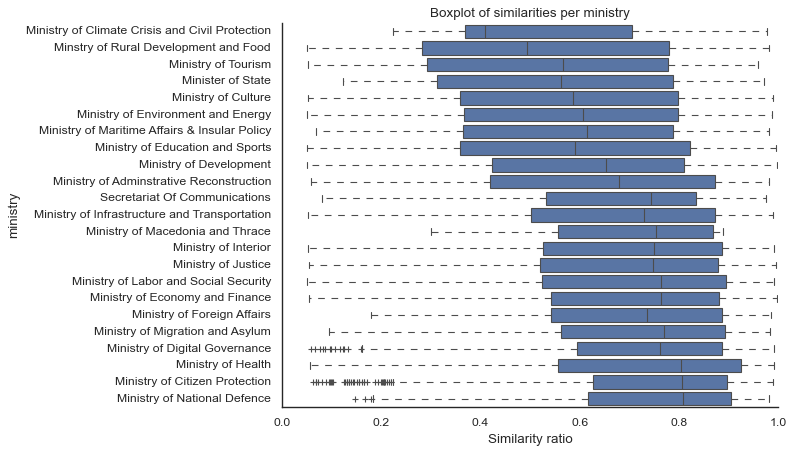

In [125]:
sns.boxplot(data=df,
            x='similarity_ratio',
            y='ministry',
            order=df.groupby('ministry')['similarity_ratio'].mean().reset_index().sort_values('similarity_ratio')['ministry']
)

plt.title("Boxplot of similarities per ministry")
plt.xlabel("Similarity ratio")
sns.despine()
plt.savefig(r"C:\Users\aneme\OneDrive\Υπολογιστής\aueb\thesis2\cleanthesis\gfx\ministries_boxplot.pdf", format="pdf", bbox_inches="tight")

<Axes: xlabel='total_comments', ylabel='Count'>

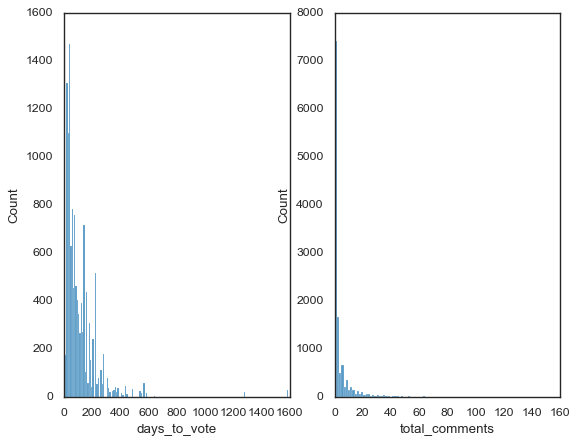

In [95]:
fig, (ax1,ax2) = plt.subplots(ncols=2)

sns.histplot(data=df,
         x='days_to_vote',
        #  hue='goverment_period',
         ax=ax1)
sns.histplot(data=df[df['total_comments']<np.quantile(df['total_comments'],q=0.99)],
         x='total_comments',bins=90,
         ax=ax2)

Text(0.5, 1.0, 'Pairplot of Total Comments, Similarity Ratio and Days to Vote')

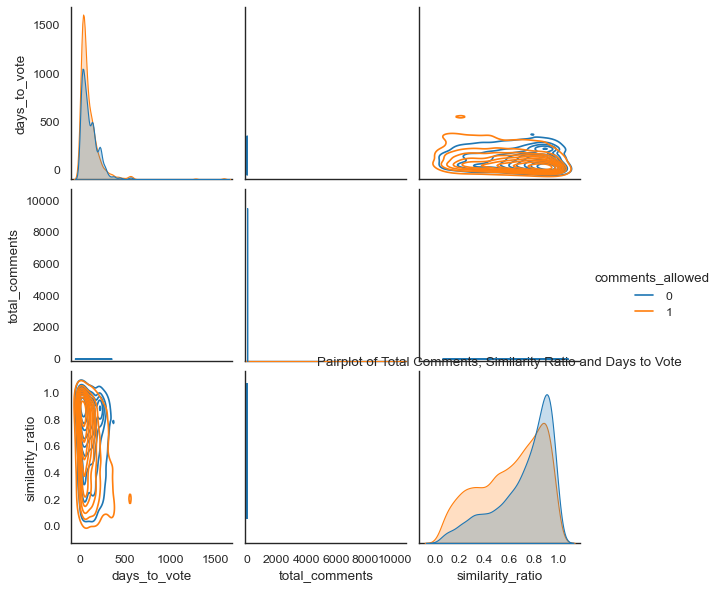

In [96]:
sns.pairplot(data=df,
             vars=['days_to_vote','total_comments','similarity_ratio'],
             kind='kde',
             hue='comments_allowed')
plt.title("Pairplot of Total Comments, Similarity Ratio and Days to Vote")

# Regressions

In [97]:
import statsmodels.api as sm
from patsy import dmatrices

In [98]:
y, X1 = dmatrices('similarity_ratio ~ total_comments', data=df, return_type='dataframe')

In [99]:
mod1 = sm.OLS(y, X1)
res1 = mod1.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:       similarity_ratio   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.416
Date:                Wed, 28 Feb 2024   Prob (F-statistic):            0.00647
Time:                        16:45:43   Log-Likelihood:                -370.16
No. Observations:               12462   AIC:                             744.3
Df Residuals:                   12460   BIC:                             759.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.6581      0.002    293.

In [100]:
y, X2 = dmatrices('similarity_ratio ~ total_comments + days_to_vote', data=df, return_type='dataframe')

In [101]:
mod2 = sm.OLS(y, X2)
res2 = mod2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:       similarity_ratio   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     404.1
Date:                Wed, 28 Feb 2024   Prob (F-statistic):          9.30e-171
Time:                        16:45:43   Log-Likelihood:                 17.739
No. Observations:               12462   AIC:                            -29.48
Df Residuals:                   12459   BIC:                            -7.186
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.7109      0.003    248.

In [102]:
y, X = dmatrices('similarity_ratio ~ total_comments_cat + days_to_vote + ministry', data=df, return_type='dataframe')

In [103]:
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       similarity_ratio   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     73.55
Date:                Wed, 28 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:45:43   Log-Likelihood:                 581.21
No. Observations:               12462   AIC:                            -1104.
Df Residuals:                   12433   BIC:                            -888.9
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [104]:
y, X3 = dmatrices('similarity_ratio ~ total_comments_cat + days_to_vote_cat', data=df, return_type='dataframe')

In [105]:
mod3 = sm.OLS(y,X3)
res3 = mod3.fit()
print(res3.summary())

                            OLS Regression Results                            
Dep. Variable:       similarity_ratio   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     147.9
Date:                Wed, 28 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:45:44   Log-Likelihood:                 456.81
No. Observations:               12462   AIC:                            -887.6
Df Residuals:                   12449   BIC:                            -791.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [106]:
y, X4 = dmatrices('similarity_ratio ~ total_comments_cat + days_to_vote_cat + goverment_period', data=df, return_type='dataframe')

In [107]:
mod4 = sm.OLS(y,X4)
res4 = mod4.fit()
print(res4.summary())

                            OLS Regression Results                            
Dep. Variable:       similarity_ratio   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     120.7
Date:                Wed, 28 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:45:44   Log-Likelihood:                 519.46
No. Observations:               12392   AIC:                            -1005.
Df Residuals:                   12375   BIC:                            -878.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [108]:
my_res = [res1,res2,res3,res4]
all_params = list()
for res in my_res:
    for param in res.params.index:
        if param not in all_params:
            all_params.append(param)

d1 = {
    'R2':(x.rsquared for x in my_res),
    'R2 Adjusted':(x.rsquared_adj for x in my_res),
    'Jarque-Bera':(x.summary().tables[2].data[1][-1] for x in my_res),
    'Jarque-Bera (Prob)' :(x.summary().tables[2].data[2][-1] for x in my_res),
    'F-Statistic' : (x.fvalue for x in my_res),
    'F-Statistic (Prob)' : (x.f_pvalue for x in my_res)
}

for param in all_params:
    # print(param, ", ", (list(x.params.get(param.strip(),None) for x in my_res)))
    d1.update({param: list((x.params.get(param.strip(),None) for x in my_res))})
    d1.update({f"{param} p_value": list((x.pvalues.get(param,None) for x in my_res))})

t = pandas.DataFrame(d1,
                    index=['Model1','Model2','Model3','Model4'])
t['Jarque-Bera'] = t['Jarque-Bera'].astype(float)
t['Jarque-Bera (Prob)'] = t['Jarque-Bera (Prob)'].astype(float)
t['days_to_vote'] = t['days_to_vote'].astype(float)
t= t.astype(float)
t.round(4).transpose().head(100)
# t.head()


,Model1,Model2,Model3,Model4
R2,0.0006,0.0609,0.1248,0.1350
R2 Adjusted,0.0005,0.0608,0.1240,0.1338
Jarque-Bera,1147.0520,1064.8580,925.0850,926.9150
Jarque-Bera (Prob),0.0000,0.0000,0.0000,0.0000
F-Statistic,7.4163,404.0771,147.9444,120.6741
F-Statistic (Prob),0.0065,0.0000,0.0000,0.0000
Intercept,0.6581,0.7109,0.8112,0.8005
Intercept p_value,0.0000,0.0000,0.0000,0.0000
total_comments,-0.0000,-0.0000,NaN,NaN
total_comments p_value,0.0065,0.0013,NaN,NaN


In [109]:
t1 = t.transpose().round(5)

t1[t1.isna()] = "-"

print(t1.to_latex())

\begin{tabular}{lllll}
\toprule
 & Model1 & Model2 & Model3 & Model4 \\
\midrule
R2 & 0.000590 & 0.060910 & 0.124810 & 0.134970 \\
R2 Adjusted & 0.000510 & 0.060760 & 0.123970 & 0.133850 \\
Jarque-Bera & 1147.052000 & 1064.858000 & 925.085000 & 926.915000 \\
Jarque-Bera (Prob) & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\
F-Statistic & 7.416270 & 404.077120 & 147.944410 & 120.674130 \\
F-Statistic (Prob) & 0.006470 & 0.000000 & 0.000000 & 0.000000 \\
Intercept & 0.658090 & 0.710890 & 0.811190 & 0.800530 \\
Intercept p_value & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\
total_comments & -0.000040 & -0.000050 & - & - \\
total_comments p_value & 0.006470 & 0.001340 & - & - \\
days_to_vote & - & -0.000480 & - & - \\
days_to_vote p_value & - & 0.000000 & - & - \\
total_comments_cat[T.50th-75th perc.(1.0,4.0]] & - & - & -0.084370 & -0.082310 \\
total_comments_cat[T.50th-75th perc.(1.0,4.0]] p_value & - & - & 0.000000 & 0.000000 \\
total_comments_cat[T.75th-90th perc.(4.0,13.0]] & - & - & -

In [110]:
y, X5 = dmatrices('similarity_ratio ~ total_comments_cat + days_to_vote_cat + goverment_period + ministry', data=df, return_type='dataframe')

In [111]:
mod5 = sm.OLS(y,X5)
res5 = mod5.fit()
print(res5.summary())

                            OLS Regression Results                            
Dep. Variable:       similarity_ratio   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     65.35
Date:                Wed, 28 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:45:45   Log-Likelihood:                 756.04
No. Observations:               12392   AIC:                            -1434.
Df Residuals:                   12353   BIC:                            -1145.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [112]:
print(res5.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                                                     & similarity\_ratio & \textbf{  R-squared:         } &     0.167   \\
\textbf{Model:}                                                             &        OLS        & \textbf{  Adj. R-squared:    } &     0.165   \\
\textbf{Method:}                                                            &   Least Squares   & \textbf{  F-statistic:       } &     65.35   \\
\textbf{Date:}                                                              &  Wed, 28 Feb 2024 & \textbf{  Prob (F-statistic):} &     0.00    \\
\textbf{Time:}                                                              &      16:45:45     & \textbf{  Log-Likelihood:    } &    756.04   \\
\textbf{No. Observations:}                                                  &        12392      & \textbf{  AIC:               } &    -1434.   \\
\textbf{Df Residuals:}                                                      & 

In [113]:
# Find baseline Ministry
for min in df['ministry'].unique():
    flag = False
    for min_cat in list(X5.columns):
        if min in min_cat:
            flag=True
    if not flag:
        print(min)


Minister of State


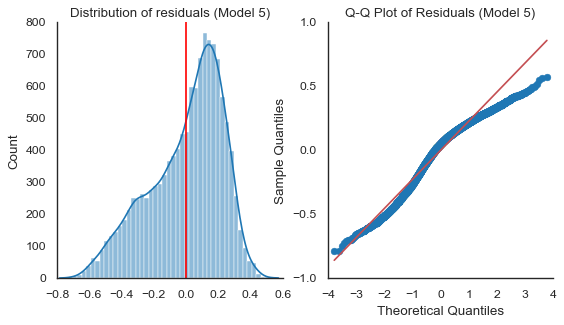

In [126]:
from statsmodels.graphics.gofplots import qqplot
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(8,4))
sns.histplot(res5.resid, kde=True,ax=ax1)
ax1.axvline(res5.resid.mean(),color='red')
ax1.set_title("Distribution of residuals (Model 5)")

qqplot(res5.resid, line='s', ax=ax2)
ax2.set_title('Q-Q Plot of Residuals (Model 5)')
sns.despine()
plt.savefig(r"C:\Users\aneme\OneDrive\Υπολογιστής\aueb\thesis2\cleanthesis\gfx\results_residuals_normality.pdf", format="pdf", bbox_inches="tight")
plt.show()

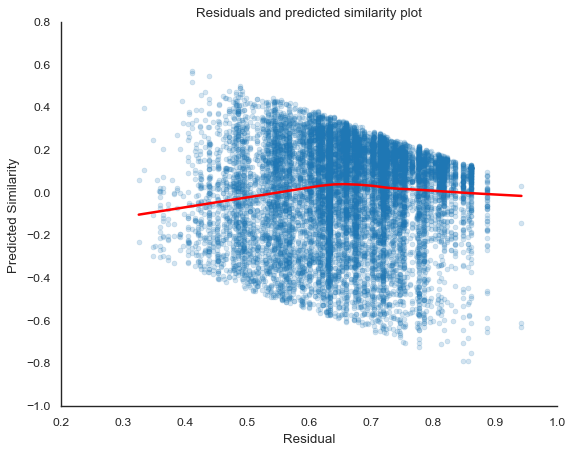

In [127]:
y_pred = res5.predict()
sns.regplot(x=y_pred, y = res5.resid,
            lowess=True,
            line_kws={'color':'red'},
            scatter_kws={'alpha':0.2})
sns.despine()
plt.ylabel("Predicted Similarity")
plt.xlabel("Residual")
plt.title("Residuals and predicted similarity plot")
plt.savefig(r"C:\Users\aneme\OneDrive\Υπολογιστής\aueb\thesis2\cleanthesis\gfx\results_yhat_resids.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [129]:
from statsmodels.stats.outliers_influence import OLSInfluence

# Calculate Cook's Distance
influence = OLSInfluence(res5)
cooks_distance = influence.cooks_distance[0]

# Cook's Distance plot
plt.stem(cooks_distance, markerfmt=".")
plt.title("Cook's Distance Plot")
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
sns.despine()
plt.savefig(r"C:\Users\aneme\OneDrive\Υπολογιστής\aueb\thesis2\cleanthesis\gfx\cooks_distance.pdf", format="pdf", bbox_inches="tight")
plt.show()